In [25]:
import numpy as np
import matplotlib.pyplot as plt
import copy

from docplex.mp.model import Model
from NPG_CMDP import CMDP_NPG
from ARNPG_CMDP import CMDP_ARNPG
import cvxpy as cp
from tqdm import tqdm

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
np.random.seed(10)
# Problem Setup
gamma = 0.8
s, a = 20, 10

raw_transition = np.random.uniform(0, 1, size=(s * a, s))
prob_transition = raw_transition / raw_transition.sum(axis=1, keepdims=1)
# Random positive rewards
reward = np.random.uniform(0, 1, size=(s * a))
# Random positive utilities
utility = np.random.uniform(0, 1, size=(s * a))
# Start state distribution
rho = np.ones(s) / s

# calculate the optimal reward via QP
model = Model()
# create continuous variables
idx = [(i, j) for i in range(s) for j in range(a)]
x = model.continuous_var_dict(idx)

for i in range(s):
    for j in range(a):
        model.add_constraint(x[i, j] >= 0)

for s_next in range(s):
    model.add_constraint(
        gamma * model.sum(x[i, j] * prob_transition[i * a + j][s_next] for i in range(s) for j in range(a))
        + (1 - gamma) * rho[s_next] == model.sum(x[s_next, a_next] for a_next in range(a)))

model.maximize(model.sum(x[i, j] * reward[i * a + j] / (1 - gamma) for i in range(s) for j in range(a)) *
               model.sum(x[i, j] * utility[i * a + j] / (1 - gamma) for i in range(s) for j in range(a)))
# search for a globally optimal solution to a nonconvex model
model.parameters.optimalitytarget = 3
model.solve()
print(np.log(model.objective_value))




2.774072238206565


In [26]:
from MDP import NPG_MDP, MO_MDP, MO_ARNPG_MDP, ARNPG_MDP

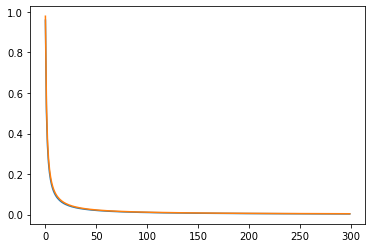

In [30]:
N = 300

theta0 = np.random.uniform(0, 1, size=s * a)
temp = NPG_MDP(reward, utility, s, a, rho, gamma, prob_transition, model=model)

for i in range(N):
    temp.NPG_step(verbose = False)

# plt.plot(temp.V1)
# plt.plot(temp.V2)
plt.plot(temp.gap)

temp = ARNPG_MDP(reward, utility, s, a, rho, gamma, prob_transition, model=model)

for i in range(N):
    temp.ARNPG_step(verbose = False)
plt.plot(temp.gap)

In [4]:
reward_num = 5

rewards = []
for i in range(reward_num):
    rewards.append(np.random.uniform(0, 1, size=(s * a)))
    

  2%|▏         | 6/300 [00:00<00:05, 54.04it/s]

6.265576476197633


100%|██████████| 300/300 [00:05<00:00, 51.46it/s]


6.264797805121378


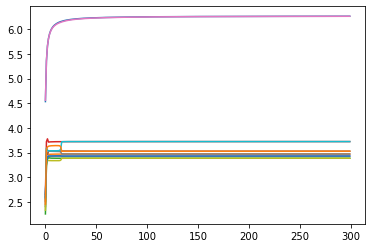

In [34]:
temp = MO_MDP(rewards, s, a, rho, gamma, prob_transition, model=model)
for i in tqdm(range(N)):
    temp.Centralized_log_NPG_step(verbose = False)
plt.plot(temp.Q_record)
plt.plot(temp.V_record[0])
plt.plot(temp.V_record[1])
plt.plot(temp.V_record[2])
plt.plot(temp.V_record[3])
plt.plot(temp.V_record[4])
print(temp.Q_record[-1])

temp = MO_ARNPG_MDP(rewards, s, a, rho, gamma, prob_transition, model=model)
for i in tqdm(range(N)):
    temp.Centalized_ARNPG_step(verbose = False)
plt.plot(temp.Q_record)
plt.plot(temp.V_record[0])
plt.plot(temp.V_record[1])
plt.plot(temp.V_record[2])
plt.plot(temp.V_record[3])
plt.plot(temp.V_record[4])
print(temp.Q_record[-1])

In [15]:
# temp = MO_ARNPG_MDP(rewards, s, a, rho, gamma, prob_transition, model=model)
# for i in tqdm(range(N)):
#     temp.Centalized_ARNPG_step(verbose = False)
# plt.plot(temp.Q_record)
# plt.plot(temp.V_record[0])
# plt.plot(temp.V_record[1])
# plt.plot(temp.V_record[2])
# plt.plot(temp.V_record[3])
# plt.plot(temp.V_record[4])
# print(temp.Q_record[-1])

In [16]:
agent_num = 5
Laplacian = np.zeros((agent_num, agent_num))

for i in range(agent_num):
    Laplacian[i,i] = -2
    Laplacian[i,(i+1)%agent_num] = 1
    Laplacian[i,(i-1)%agent_num] = 1
print(Laplacian)

W = np.zeros((agent_num, agent_num))
eta = 0.1
for i in range(agent_num):
    W[i,i] = 1-2*eta
    W[i,(i+1)%agent_num] = eta
    W[i,(i-1)%agent_num] = eta
print(W)

[[-2.  1.  0.  0.  1.]
 [ 1. -2.  1.  0.  0.]
 [ 0.  1. -2.  1.  0.]
 [ 0.  0.  1. -2.  1.]
 [ 1.  0.  0.  1. -2.]]
[[0.8 0.1 0.  0.  0.1]
 [0.1 0.8 0.1 0.  0. ]
 [0.  0.1 0.8 0.1 0. ]
 [0.  0.  0.1 0.8 0.1]
 [0.1 0.  0.  0.1 0.8]]


In [19]:
agent_list = []
for i in range(agent_num):
    agent_list.append(MO_MDP(rewards, s, a, rho, gamma, prob_transition, model=model))
# for k in range(5):
old_grad = np.zeros((agent_num, reward_num))
grad = np.zeros((agent_num, reward_num))
y = np.zeros((agent_num, reward_num))
all_theta = np.zeros((agent_num, s*a))
N = 1000
for k in tqdm(range(N)):
    
    for i in range(agent_num):
        grad[i] = agent_list[i].calculate_G(num=i,verbose = False)
        all_theta[i] = copy.deepcopy(agent_list[i].theta)

    y = W@y+grad-old_grad
#     y = W@grad
#     y = copy.deepcopy(grad)
#     y = y + eta*Laplacian@grad
    old_grad = copy.deepcopy(grad)
    all_theta = W@all_theta
        
    for i in range(agent_num):
        agent_list[i].theta=all_theta[i]
        agent_list[i].NPG_step_given_G(y[i], verbose = False)
        

100%|██████████| 1000/1000 [01:31<00:00, 10.89it/s]


100%|██████████| 1000/1000 [01:31<00:00, 10.98it/s]


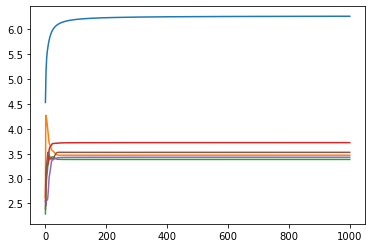

In [20]:
plt.plot(agent_list[0].Q_record)
plt.plot(agent_list[0].V_record[0])
plt.plot(agent_list[0].V_record[1])
plt.plot(agent_list[0].V_record[2])
plt.plot(agent_list[0].V_record[3])
plt.plot(agent_list[0].V_record[4])

6.260563299332715
6.260351053354455
6.260190391089924
6.2587522587202145
6.260350491053379


AttributeError: 'ARNPG_MDP' object has no attribute 'Q_record'

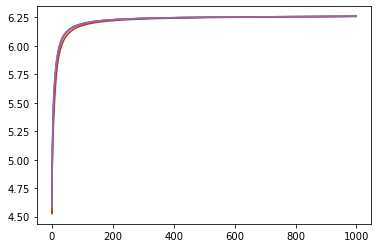

In [33]:
for i in range(agent_num):
    plt.plot(agent_list[i].Q_record)
    print(agent_list[i].Q_record[-1])
plt.plot(temp.Q_record)

In [28]:
agent_list = []
for i in range(agent_num):
    agent_list.append(MO_ARNPG_MDP(rewards, s, a, rho, gamma, prob_transition, model=model))
# for k in range(5):
old_grad = np.zeros((agent_num, reward_num))
grad = np.zeros((agent_num, reward_num))
y = np.zeros((agent_num, reward_num))
all_theta = np.zeros((agent_num, s*a))
N = 1000
for k in tqdm(range(N)):
    
    for i in range(agent_num):
        grad[i] = agent_list[i].calculate_G(num=i,verbose = False)
        all_theta[i] = copy.deepcopy(agent_list[i].theta)

    y = W@y+grad-old_grad
#     y = W@grad
#     y = copy.deepcopy(grad)
#     y = y + eta*Laplacian@grad
    old_grad = copy.deepcopy(grad)
    all_theta = W@all_theta
        
    for i in range(agent_num):
        agent_list[i].theta=all_theta[i]
        agent_list[i].NPG_step_given_G(y[i], verbose = False)

100%|██████████| 1000/1000 [01:30<00:00, 10.99it/s]


6.260563299332715
6.260351053354455
6.260190391089924
6.2587522587202145
6.260350491053379


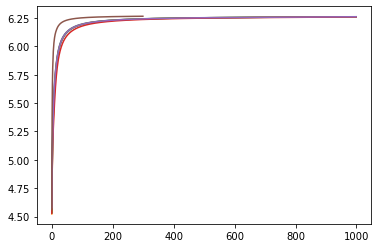

In [35]:
for i in range(agent_num):
    plt.plot(agent_list[i].Q_record)
    print(agent_list[i].Q_record[-1])
plt.plot(temp.Q_record)

In [86]:
print(y)

[[-58.93044799  31.33908152   0.           0.          33.17419591]
 [ 29.46522399 -62.67816303  32.53035047   0.           0.        ]
 [  0.          31.33908152 -65.06070095  32.13678195   0.        ]
 [  0.           0.          32.53035047 -64.27356389  33.17419591]
 [ 29.46522399   0.           0.          32.13678195 -66.34839182]]


In [17]:
# # calculate the optimal reward via QP
# model = Model()
# # create continuous variables
# idx = [(i, j) for i in range(s) for j in range(a)]
# x = model.continuous_var_dict(idx)

# for i in range(s):
#     for j in range(a):
#         model.add_constraint(x[i, j] >= 0)

# for s_next in range(s):
#     model.add_constraint(
#         gamma * model.sum(x[i, j] * prob_transition[i * a + j][s_next] for i in range(s) for j in range(a))
#         + (1 - gamma) * rho[s_next] == model.sum(x[s_next, a_next] for a_next in range(a)))
# temp = 1
# # for reward in rewards:
# #     temp = temp *model.sum(x[i, j] * reward[i * a + j] / (1 - gamma) for i in range(s) for j in range(a))
# # model.maximize(temp)
# model.maximize((model.sum(x[i, j] * reward[i * a + j] / (1 - gamma) for i in range(s) for j in range(a))))
# # model.maximize((model.sum(x[i, j] * reward[i * a + j] / (1 - gamma) for i in range(s) for j in range(a)) *
# #                model.sum(x[i, j] * utility[i * a + j] / (1 - gamma) for i in range(s) for j in range(a))))
# # search for a globally optimal solution to a nonconvex model
# model.parameters.optimalitytarget = 3
# model.solve()
# print(np.log(model.objective_value))

In [18]:
# one_vec = np.ones(a)
# x = cp.Variable((s*a))
# print(x.shape, reward.shape, cp.scalar_product(x, reward / (1 - gamma) ).shape, (x@prob_transition).shape)
# print((x@prob_transition).shape, rho.shape, (cp.reshape(x,(s,a))@one_vec).shape)
# print(x,cp.reshape(x,(s,a)))

In [13]:
# # constraint = []
# # for s_next in range(s):
# #     for j in range(a):
# # constraint = [gamma*x@prob_transition+ (1 - gamma) * rho==cp.reshape(x,(s,a))@one_vec, x>=0]
# constraint = [gamma*x@prob_transition+ (1 - gamma) * rho==one_vec@cp.reshape(x,(a,s)), x>=0]


# # objective = cp.Maximize(cp.multiply(cp.scalar_product(x, reward / (1 - gamma) ),cp.scalar_product(x, reward / (1 - gamma) ) ))
# objective = cp.Maximize((cp.sum(cp.multiply(x,reward / (1 - gamma))) )*(cp.sum(cp.multiply(x,reward / (1 - gamma))) ))

# prob = cp.Problem(objective, constraint)

# # result = prob.solve(solver='GLPK_MI')
# result = prob.solve(solver='SCIP')
# print(np.log(result))

In [14]:
# gamma * model.sum(x[i, j] * prob_transition[i * a + j][s_next] for i in range(s) for j in range(a))
#         + (1 - gamma) * rho[s_next] == model.sum(x[s_next, a_next] for a_next in range(a))

# # objective = cp.Minimize(cp.sum([[x[i, j] * reward[i * a + j] / (1 - gamma) for i in range(s)] for j in range(a)]))

# objective = cp.scalar_product(x.T, reward / (1 - gamma) )

In [15]:
# constraint = gamma * model.sum(x[i, j] * prob_transition[i * a + j][s_next] for i in range(s) for j in range(a)) 
# + (1 - gamma) * rho[s_next] == model.sum(x[s_next, a_next] for a_next in range(a))

In [16]:
# import pyscipopt